## Homework 4 Part I

In [21]:
import numpy as np; import pymc as pm; import arviz as az; from scipy import stats

In [22]:
# Importing the value for data
n,loc_true,scale_true,df_true = 100,10,2,15
data = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

In [23]:
model = pm.Model()

with model:
    
    # Priors
    loc = pm.Normal('loc', mu = 0, sigma = 10)
    scale = pm.HalfNormal('scale', sigma = 5)
    df = pm.DiscreteUniform('df', lower=1, upper=101)
    
    # Distribution - Student's T log-likelihood
    observed = pm.StudentT('observed', nu=df, mu=loc, lam=1/scale**2, observed = data)    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


[[<Axes: title={'center': 'loc'}> <Axes: title={'center': 'loc'}>]
 [<Axes: title={'center': 'df'}> <Axes: title={'center': 'df'}>]
 [<Axes: title={'center': 'scale'}> <Axes: title={'center': 'scale'}>]]


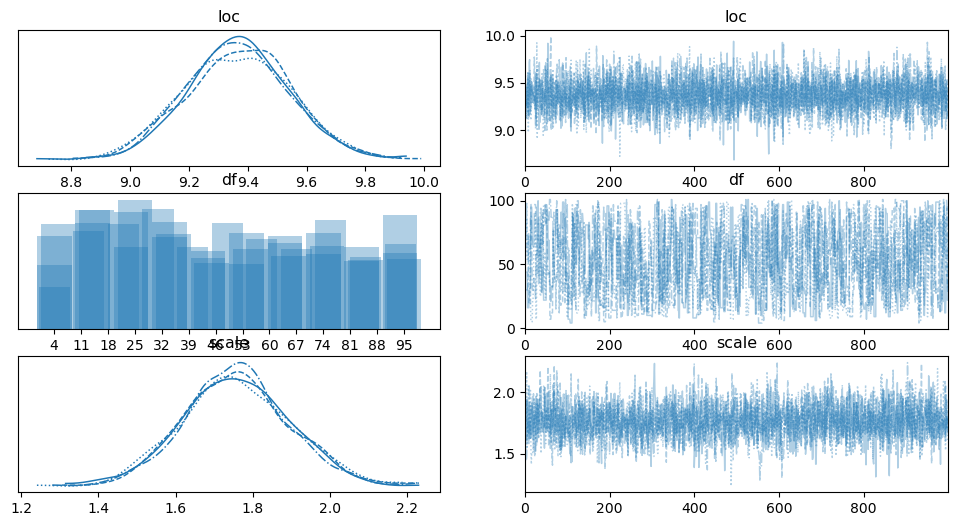

In [24]:
with model:
    trace_convergence_check = pm.sample()

print(az.plot_trace(trace_convergence_check))

## Homework 4 Part II

### Analysis form Part I

In [25]:
with model:
    trace_convergence_check = pm.sample()

#ess
az.summary(trace_convergence_check, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,9.36,0.18,9.01,9.69,0.00,0.00,3922.60,2797.31,1.00
df,50.54,28.26,6.00,96.00,1.11,0.78,646.87,556.58,1.01
scale,1.76,0.14,1.49,2.03,0.00,0.00,1683.13,1519.27,1.00


From the summary above, we can obtain the effective sample size (ess) from the "ess_bulk" and "ess_tail" column, and the value suggests that the chain might be working efficiently. Meanwhile, chain convergence measures are close or equal to 1, as shown above, indicating that the chains are converaged. As for the divergence, there appears to be no divergences.

(array([  32.,   28.,   50.,   82.,  157.,  234.,  306.,  475.,  636.,
        2000.]),
 array([0.00121935, 0.10109742, 0.20097548, 0.30085355, 0.40073161,
        0.50060968, 0.60048774, 0.70036581, 0.80024387, 0.90012194,
        1.        ]),
 <BarContainer object of 10 artists>)

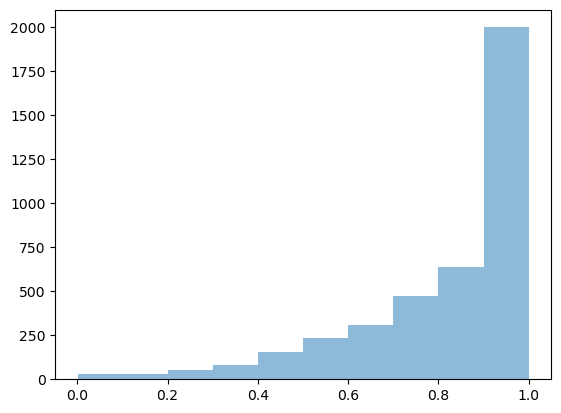

In [26]:
import matplotlib.pyplot as plt

plt.hist(trace_convergence_check.sample_stats.acceptance_rate.values.flatten(), alpha = 0.5)

Metropolis-Hastings acceptance rates can be shown as the plot above. Based on the plot, we can see that the acceptance rates are overall high bacause it is left-skewed, indicating that the sample was accepted most of the time.

### Eight Schools example

In [27]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [28]:
import pymc as pm

In [29]:
with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

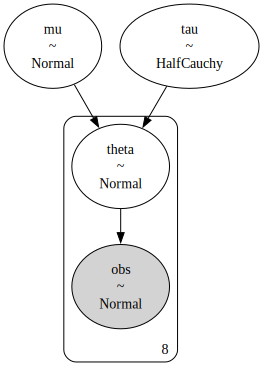

In [30]:
pm.model_to_graphviz(Centered_eight)

In [31]:
# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] 
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [32]:
import logging 
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20


In [15]:
# We now see that the NUTS implementation (version of HMC) is being used to
# sample from the posterior distributions of our parameters [mu, tau, theta]
SEED = [20100420, 20134234]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [17]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


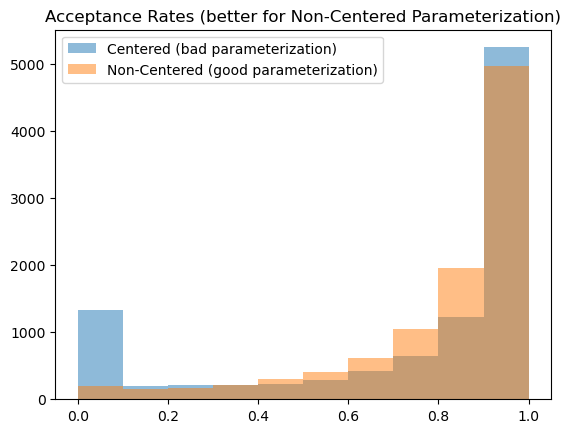

In [18]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

In [19]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,742.0,11904.0
tau,60.0,5956.0
theta[0],1179.0,9879.0
theta[1],1366.0,11655.0
theta[2],1754.0,10704.0
theta[3],1808.0,11938.0
theta[4],1724.0,12008.0
theta[5],1960.0,11047.0
theta[6],1087.0,10834.0
theta[7],1947.0,10959.0


#### Anologous Report

ESS:
    Through the output of ESS for the non-centered and centered model, the effective sample size is much smaller for the centered model. Unlike the non-centered model, for which the sizes are close to actual number of iterations, the ESS for centered model indicate a high autocorrelation.

Divergence:
    Comparing with the number of divergences of 433 respectively for the two chains for the centered model, the number was much more lower for the uncentered model, with the output of 12 divergences, showing that the parametization is better in the uncentered model than the centered one.

Metropolis-Hastings Acceptance Rates:
    Based on the histograms that was constructed from the acceptance rates of the two models, it is clear that the non-centered model has a higher acceptance rate.

##### From the perspective of curvature of the energy function and the effectiveness of the HMC algorithm

For a non-centered parametization, there would usually have less curvatures, and the exploration for HMC algorithms  would be more efficient because less steps are required.

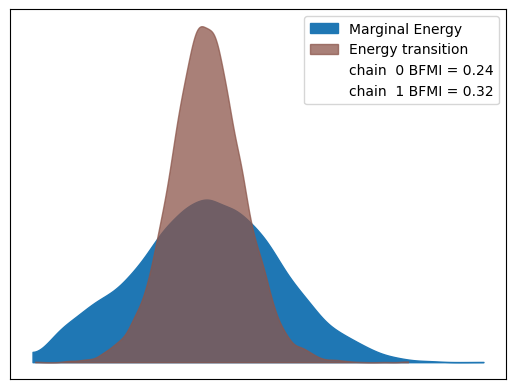

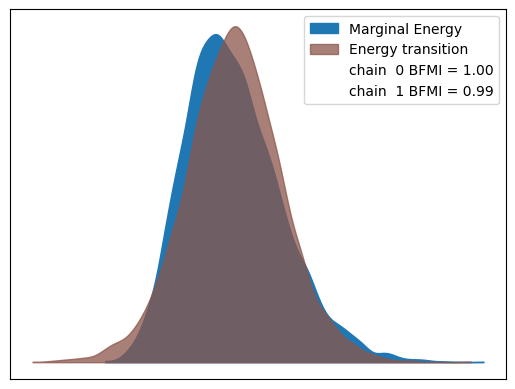

In [20]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

For the centered parameterization, there is a clear gap between the distributions of marginal energy and energy transition. Since they are not very much overlapper, implying that it does not accurately match the actual energy distribution.

However, for the uncentered parameterization, the marginal energy and energy transition distributions are largely overlapped, indicating that the parameterization is considerably efficient.

Hence, the diagnostic overall supports the previous conclusions.